/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


wave shape: torch.Size([341064])
mel_spectrogram shape: torch.Size([100, 1333])


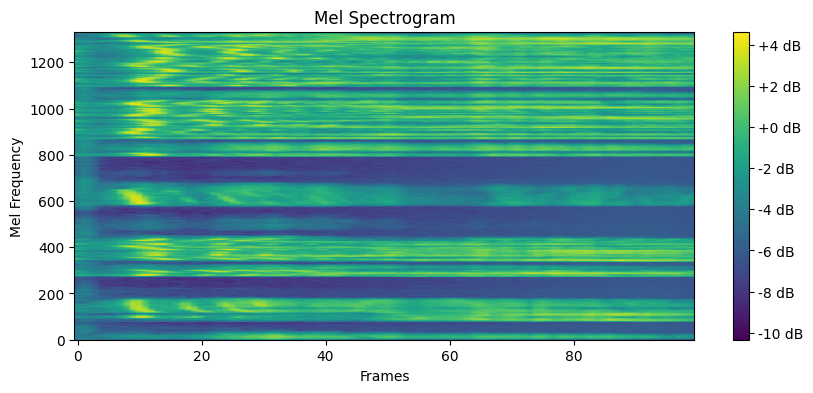

/var/folders/p3/yt773s8171n4tjq59pq7__km0000gn/T/ipykernel_77816/42613300.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  Audio(waveform.T, rate=sample_rate)


In [1]:
import torch
import torchaudio
from vocos.feature_extractors import MelSpectrogramFeatures
import matplotlib.pyplot as plt
from IPython.display import Audio

# 加载音频文件
audio_path = '/private/tmp/three_moon/side2_lc1_mar7th_224.wav'
sample_rate = 24000
waveform, sr = torchaudio.load(audio_path)
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0)
if sr != sample_rate:
    waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
print(f"wave shape: {waveform.shape}")

# 创建MelSpectrogramFeatures实例
mel_spec_extractor = MelSpectrogramFeatures(sample_rate=sample_rate, n_fft=1024, hop_length=256, n_mels=100)

# 将音频转换为Mel频谱图
mel_spectrogram = mel_spec_extractor(waveform)
print(f"mel_spectrogram shape: {mel_spectrogram.shape}")

# 使用matplotlib绘制Mel频谱图
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram.T, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Frames')
plt.ylabel('Mel Frequency')
plt.show()
Audio(waveform.T, rate=sample_rate)

torch.Size([100, 1333])
MSE:	0.015685291960835457


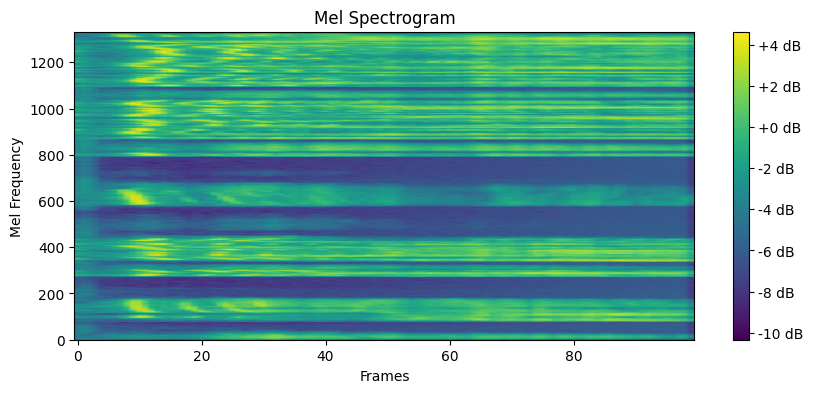

In [8]:
import librosa
from vocos.modules import safe_log

audio_librosa, sr = librosa.load(audio_path, sr=sample_rate, mono=True)
if isinstance(audio_librosa, torch.Tensor):
    # 转换回numpy
    audio_librosa = audio_librosa.numpy()
S = librosa.feature.melspectrogram(y=audio_librosa,
                                   sr=sample_rate,
                                   n_mels=100,
                                   n_fft=1024,
                                   hop_length=256,
                                   power=1,
                                   htk=True,
                                   center=True,
                                   norm=None,
                                   pad_mode="reflect")
S = torch.from_numpy(S)
print(S.shape)

# 应用对数变换
log_S = S
log_S = safe_log(S)


mse = ((mel_spectrogram - log_S) ** 2).mean()

print(f'MSE:\t{mse}')

# 使用matplotlib绘制Mel频谱图
plt.figure(figsize=(10, 4))
plt.imshow(log_S.T, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Frames')
plt.ylabel('Mel Frequency')
plt.show()

In [3]:
print(((waveform-audio_librosa)**2).mean())

tensor(1.0956e-06)


# 加载模型将Mel频谱图转换回音频信号

In [6]:
import torch
from IPython.display import Audio

from vocos import Vocos

model = Vocos.from_hparams("/private/tmp/ChatTTS/config/vocos.yaml").eval()
model.load_state_dict(torch.load("/private/tmp/ChatTTS/asset/Vocos.pt"))

with torch.no_grad():
    audio = model.decode(log_S[None])
Audio(audio.cpu().numpy(), rate=sample_rate)